In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-data-1/RestaurantVisitors.csv
/kaggle/input/time-series-data-1/DailyTotalFemaleBirths.csv
/kaggle/input/time-series-data-1/TradeInventories.csv
/kaggle/input/time-series-data-1/M2SLMoneyStock.csv
/kaggle/input/time-series-data-1/PCEPersonalSpending.csv
/kaggle/input/time-series-data-1/uspopulation.csv
/kaggle/input/time-series-data-1/macrodata.csv
/kaggle/input/time-series-data-1/airline_passengers.csv
/kaggle/input/time-series-data-1/co2_mm_mlo.csv


# VAR - Vector AutoRegression
VAR is used when there are variables which have an effect on each other. In case of restaurant visitors where the exogenous variable $holidays$ affected the $visitors$, it wasn't vice versa. However, there are many cases in which two variables have an effect on each other. Example is Personal Disposable Income affects the Spending and the amount of Spending is affected by the available Personal Disposable income in the hands of the people. The dataset here contains the income in the hands of the people and another dataset contains the spending. 

## Imports and Load the dataset

In [2]:
import numpy as np
import pandas as pd

# visualization import
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('/kaggle/input/time-series-data-1/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('/kaggle/input/time-series-data-1/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'


## Inspect the data

In [3]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [4]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


Spending is correlated with the money in hand and vice versa. We need to join these two dataframes into one for our model. The datetime index is the same and that makes the joining task easy. 

In [5]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [6]:
# check for null or missing values
df.isna().sum()

Money       0
Spending    0
dtype: int64

Cool, so we do not have any null values in the dataset.

In [7]:
# the number of instances
len(df)

252

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1995-01-01 to 2015-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Money     252 non-null    float64
 1   Spending  252 non-null    float64
dtypes: float64(2)
memory usage: 15.9 KB


The datatype of the two features is also fine. All hygiene checks done. we will test for stationarity using the augmented dikcey fuller test.

## Plot the source data

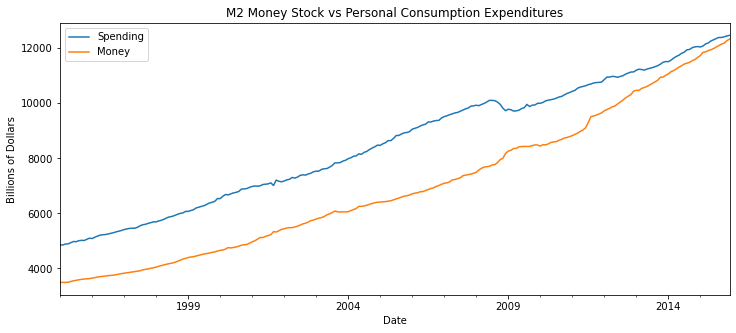

In [9]:
title = 'M2 Money Stock vs Personal Consumption Expenditures'
ylabel = 'Billions of Dollars'
xlabel='' #xlabel is not required. The datetime indes will be taken as the points on the x axis

ax = df['Spending'].plot(legend=True,title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel,ylabel=ylabel)
df['Money'].plot(legend=True);

In [10]:
def dickey_fuller(series,title='Your Dataset'):
    '''Hypothesis Test for stationarity '''
    print(f'Augmented Dickey Fuller Test for the dataset {title}')
    
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')
        
    
    
    

In [11]:
dickey_fuller(df['Money'],title='Money')

Augmented Dickey Fuller Test for the dataset Money
ADF test statistics       4.239022
p-value                   1.000000
#lags                     4.000000
#observations           247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


In [12]:
dickey_fuller(df['Spending'],title='Spending')

Augmented Dickey Fuller Test for the dataset Spending
ADF test statistics       0.149796
p-value                   0.969301
#lags                     3.000000
#observations           248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


So both the Money and the Spending is non stationary. We will take the first order difference of the entire dataframe and re-run the dickey fuller test and store it in a separate dataframe so that the original dataframe is retained. 

In [13]:
df_diff = df.diff() # by default, diff performs the first order difference

In [14]:
df_diff.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9


There is NaN introduced due to the first order difference. So lets drop this missing value row.

In [15]:
df_diff = df_diff.dropna()

In [16]:
dickey_fuller(df_diff['Money'],title='Money 1st Order Diff')

Augmented Dickey Fuller Test for the dataset Money 1st Order Diff
ADF test statistics      -2.057404
p-value                   0.261984
#lags                    15.000000
#observations           235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


In [17]:
dickey_fuller(df_diff['Spending'],title='Spending 1st Order Diff')

Augmented Dickey Fuller Test for the dataset Spending 1st Order Diff
ADF test statistics    -7.226974e+00
p-value                 2.041027e-10
#lags                   2.000000e+00
#observations           2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Money feature is still not stationary while Spending is stationary after the first order difference. I will take the second order difference of both the series so that they retain the same shape. Rerun the dickey fuller test for stationarity.

In [18]:
df_diff = df_diff.diff().dropna()
dickey_fuller(df_diff['Money'],title='Money 2nd Order Diff')

Augmented Dickey Fuller Test for the dataset Money 2nd Order Diff
ADF test statistics    -7.077471e+00
p-value                 4.760675e-10
#lags                   1.400000e+01
#observations           2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [19]:
dickey_fuller(df_diff['Spending'],title='Spending 2nd Order Diff')

Augmented Dickey Fuller Test for the dataset Spending 2nd Order Diff
ADF test statistics    -8.760145e+00
p-value                 2.687900e-14
#lags                   8.000000e+00
#observations           2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Now, both the correlated features - Money and Spending are stationary. Hence we are good to go with the remaining steps of training, test predictions and finally forecasting into the future.

In [20]:
df_diff.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [21]:
# check the length of the transformed df -- > should be 2 rows lesser than the original
len(df_diff)

250

## Train Test Split


In [22]:
nobs = 12
train = df_diff[:-nobs]
test = df_diff[-nobs:]

In [23]:
len(train), len(test)

(238, 12)

## VAR Model Order Selection 
VAR(p) of order p

So far in my other notebooks on time series on ARIMA and SARIMA, I used the auto_arima from pmdarima library. That method won't work here to determine the order of the VAR model. I will test this manually with a list of order p values and select the p value which returns the minimum AIC or BIC metric. Check Akaike Information Criterion and Bayesian Information Criterion for more details.

In [24]:
p = [1,2,3,4,5,6,7]  # try with list of 7 p values

for i in p:
    model = VAR(train)
    results = model.fit(i)
    print(f'VAR Order {i}')
    print('AIC {}'.format(results.aic))
    print('BIC {}'.format(results.bic))
    print()

VAR Order 1
AIC 14.178610495220896
BIC 14.266409486135709

VAR Order 2
AIC 13.955189367163705
BIC 14.101961901274958

VAR Order 3
AIC 13.849518291541038
BIC 14.055621258341116

VAR Order 4
AIC 13.827950574458281
BIC 14.093744506408875

VAR Order 5
AIC 13.78730034460964
BIC 14.113149468980652

VAR Order 6
AIC 13.799076756885807
BIC 14.185349048538066

VAR Order 7
AIC 13.797638727913972
BIC 14.244705963046671



Order 5 has the least AIC value. Lets select p = 5 in the modeling.

In [25]:
# lets confirm that both the variables are included in the model
model.endog_names

['Money', 'Spending']

## Fit the VAR(5) model

In [26]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Dec, 2020
Time:                     05:23:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

Check the correlation matrix printed at the last. 

## Predict the next 12 values
For predictions, VAR model uses .forecast() instead of predictions. This is similar to theHolt Winters. One of the requirement for VAR model is that we need to pass the lag order of the number of previous observations as well. Unfortunately, this lag order does not have the datetime index and hence we will have to build this ourselves.

In [27]:
lag_order = results.k_ar
lag_order

5

In [28]:
z = results.forecast(y=train.values[-lag_order:],steps = 12)
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [29]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [30]:
idx = pd.date_range(start='1/1/2015',periods=12,freq='MS')
df_forecast = pd.DataFrame(z,index=idx,columns=['Money2D','Spending2D'])

In [31]:
df_forecast[:5]

,Money2D,Spending2D
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365


## Invert the Transformations

The forecasted values represent the 2nd order difference forecast. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

In [32]:
df_forecast['Money1D'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + df_forecast['Money2D'].cumsum()

In [33]:
# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1D'].cumsum()

In [34]:
df_forecast

,Money2D,Spending2D,Money1D,MoneyForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371
2015-04-01,-2.602233,5.479458,55.450728,11903.639099
2015-05-01,4.228557,-2.443365,59.679285,11963.318384
2015-06-01,1.559393,0.387639,61.238678,12024.557062
2015-07-01,-0.998410,3.883680,60.240268,12084.797331
2015-08-01,0.364510,-2.356101,60.604779,12145.402109
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261
2015-10-01,0.225877,0.786927,59.620028,12264.416289


Similarly,lets do this for the spending column

In [35]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1D'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending2D'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1D'].cumsum()

In [36]:
df_forecast

,Money2D,Spending2D,Money1D,MoneyForecast,Spending1D,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019



## Plot the results

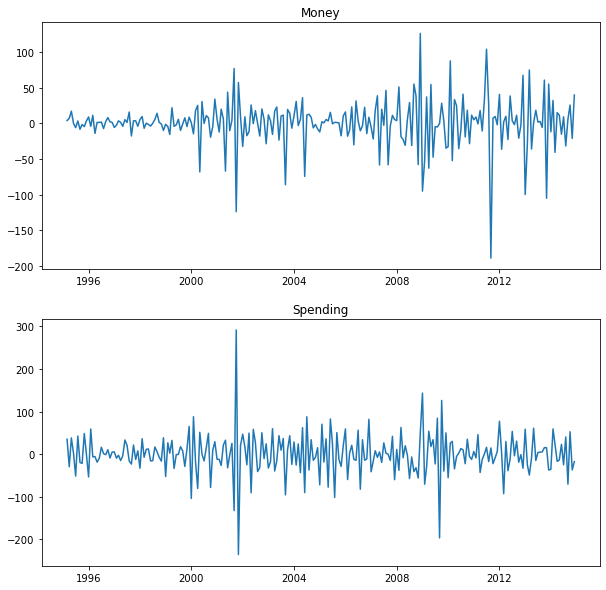

In [37]:
results.plot();

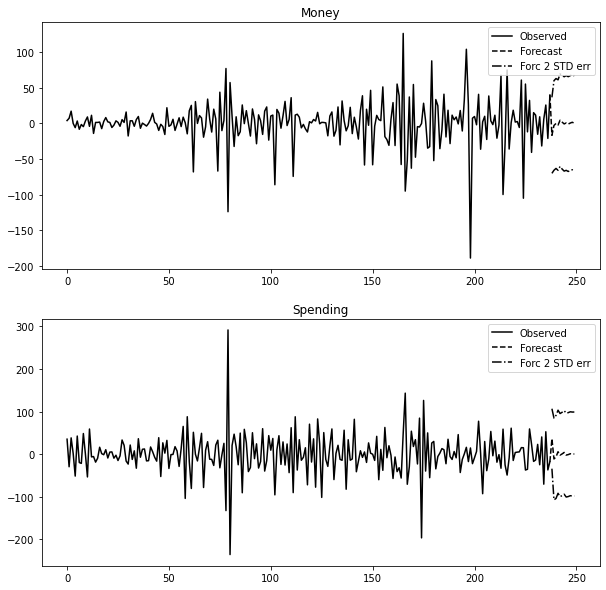

In [38]:
results.plot_forecast(12);

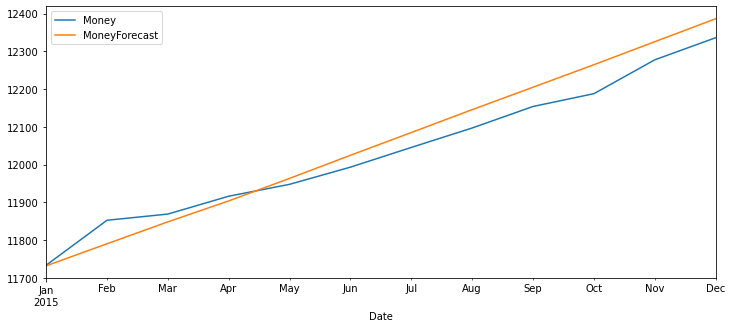

In [39]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

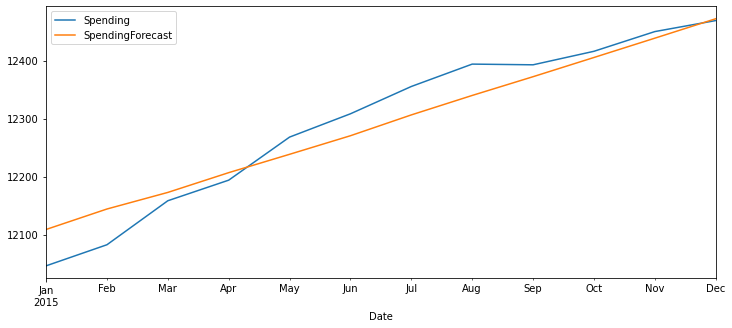

In [40]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

## Model Evaluation

In [41]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 43.710


In [42]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 37.001
